# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

##  Homework 7: Generative Models - Variational Autoencoders and GANs [100 pts]


**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Pavlos Protopapas, Mark Glickman and Chris Tanner<br/>

**DISCLAIMER**: No public reproduction of this homework nor its solution is allowed without the explicit consent of their authors.

<hr style="height:2pt">

---



In [0]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
#mount your own drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- For this homework **you do NOT need to restart the kernel and run the whole notebook again before you submit**.
- **You should SAVE your models, and do not retrain on notebook reruns**.
- In this homework we import general keras library objects. Feel free to experiment and use different layers, optimizers, random initializers... whater you like using from the core libraries we import.
- Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

---

<div class="theme"> Overview </div> 

We are going to compare autoencoders (AEs), variational autoencoders (VAEs) and generative adversarial networks (GANs). The goal is to understand the particularities of each model and to learn how to build them. 

In addition to standard VAEs, we will also study conditional VAEs. Conditional VAEs incorporate input attributes on the latent representation of an input, providing some structure in the latent space. We will analyze how conditioal VAEs are capable of generating new photos according that depend on specified attributes. 

We are going to train our networks using [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), which is a large-scale face attributes dataset with more than 200K celebrity images and 40 different attribute annotations.

Run the following cell to load important libraries.

In [0]:
# Load useful libraries
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *

# Plotting libraries
import matplotlib.pyplot as plt
plt.gray()

<Figure size 432x288 with 0 Axes>

**Check availability of GPU**

Run this line to verify your instance is lists an available GPU.

In [0]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---

**Dowload CelebA Dataset**

Make sure to have `tensorflow_datasets` installed on version 2.1.0 before running following cell. You can install by running the following code on a **terminal** (not from Jupyter):

```pip install tensorflow_datasets==2.1.0```

Download CelebA if you have not downloaded it already. You can use the following line to download manually from a **terminal**:

```wget https://cs109b2020.s3.amazonaws.com/2.0.0.zip```

Uncompress it under ```~/tensorflow_datasets/celeb_a/2.0.0/```.


In [0]:
!git clone https://github.com/rashmibanthia/2.0.0.git ~/tensorflow_datasets/celeb_a/2.0.0/

Cloning into '/root/tensorflow_datasets/celeb_a/2.0.0'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
^C


In [0]:
# Run this cell
# Assumes CelebA has been manually downloaded and is available in `~/tensorflow_datasets/celeb_a/2.0.0/`.

import tensorflow_datasets as tfds

train_celeb, val_celeb = tfds.load('celeb_a', split=['train', 'validation'], shuffle_files=False,  data_dir = 'gdrive/My Drive/',download=False)

In [0]:
# Global variables to define training/loading models. 
# Modify as required. These are only suggested parameters.

train = True
epochs = 5  # number of epochs to train models
batch_size = 32
input_size = (64, 64, 3)  # images will be cropped and resized to `input_size`.

---

## <div class='exercise'><b>Question 1: Preprocess and visualize the data [20 pts]</b></div>

CelebA has 202,599 face images of various celebrities and training on the whole set requires large computational resources to fit your models. For this reason we recommend cropping the images and resizing them to reduce to computational costs. Feel free to adjust the images resolution depending on your computation capabilities. We recommend using `image_size = (64,64,3)`, but feel free to use a larger resolution, or smaller, up to `image_size = (32,32,3)`. 

We provide the function `tf_norm_crop_resize_image` to normalize image pixels between `[0,1]`, to crop the height and width of images to `150x150` pixels, and to [resize](https://www.tensorflow.org/api_docs/python/tf/image/resize) images to the indicated size in the function call. Follow the intructions below to format your data for the different models you will need to train:

**1.1** Create training and validation Dataset pipelines `train_ds` and `val_ds` from `train_celeb` and `val_celeb`, respectively. The Dataset pipelines you create have to return a tuple `(image, image)` which you will use to train your models with an MSE loss criteria: the first element is the input fed to the model, the second element is used to compute the loss of the model.

Make sure the Datasets follow this pipeline: 1) normalize, crop, resize and follows format (use [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)), 2) [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), 3) [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), and 4) [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) (optional).  

**1.2** Create training and validation Dataset pipelines `train_cond_ds` and `val_cond_ds` from `train_celeb` and `val_celeb`, respectively. The Dataset pipelines you create have to return a tuple `((image, attributes), image)` to train your conditional VAE model. The first element of the tuple corresponds to the input of the model and consists of two tensors: the image and 2 selected attributes of your choice (for example, `Male` and `Smiling` attributes). You can choose your attributes from the ones [available](https://www.tensorflow.org/datasets/catalog/celeb_a). Make sure the attributes you use are easily identifiable in the images because you will need to alter them and expect visual changes (see Question 4.3). Convert the boolean attributes to `tf.float32` using [`tf.cast`](https://www.tensorflow.org/api_docs/python/tf/cast).

Make sure the Datasets follow this pipeline: 1) normalize, crop, resize and satisfies input-output format (use [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)), 2) [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), 3) [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), and 4) [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) (optional). 

**1.3** Pick 5 random images from the train dataset and plot them. List the attributes from these images and verify they are correct.


**Final Note:** 
When training your models, if you find that the training set is too large and models take too long to train, you may select a portion of the train set and use that only. Adjust this value on your [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) pipeline by using the method [`take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take). Make sure that your delivered images with AE, VAEs, CVAE and GAN look nice. For reference, out solution took 100 min to train in JupyterHub for all models, and 70 min in Colab, from beginning to end, on the full training data.

In [0]:
# DO NOT DELETE THIS CELL
# Use this function to normalize, crop and resize your images.
def tf_norm_crop_resize_image(image, resize_dim):
    """Normalizes image to [0.,1.], crops to dims (150, 150, 3)
    and resizes to `resize_dim`, returning an image tensor."""
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, 150, 150)
    image = tf.image.resize(image, resize_dim)
    image.set_shape(resize_dim + (3,))
    return image

## Answers

**1.1** Create training and validation Dataset pipelines `train_ds` and `val_ds` from `train_celeb` and `val_celeb`, respectively. The Dataset pipelines you create have to return a tuple `(image, image)` which you will use to train your models with an MSE loss criteria: the first element is the input fed to the model, the second element is used to compute the loss of the model.

Make sure the Datasets follow this pipeline: 1) normalize, crop, resize and follows format (use [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)), 2) [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), 3) [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), and 4) [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) (optional).  

In [0]:
train_ds = train_celeb.map(lambda img: tf_norm_crop_resize_image(img["image"],input_size[:2]))
train_ds = train_ds.map(lambda img: (img,img))
train_ds = train_ds.shuffle(20)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(10)

val_ds = train_celeb.map(lambda img: tf_norm_crop_resize_image(img["image"],input_size[:2]))
val_ds = val_ds.map(lambda img: (img,img))
val_ds = val_ds.shuffle(20)
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(10)

NameError: ignored

**1.2** Create training and validation Dataset pipelines `train_cond_ds` and `val_cond_ds` from `train_celeb` and `val_celeb`, respectively. The Dataset pipelines you create have to return a tuple `((image, attributes), image)` to train your conditional VAE model. The first element of the tuple corresponds to the input of the model and consists of two tensors: the image and 2 selected attributes of your choice (for example, `Male` and `Smiling` attributes). You can choose your attributes from the ones [available](https://www.tensorflow.org/datasets/catalog/celeb_a). Make sure the attributes you use are easily identifiable in the images because you will need to alter them and expect visual changes (see Question 4.3). Convert the boolean attributes to `tf.float32` using [`tf.cast`](https://www.tensorflow.org/api_docs/python/tf/cast).

Make sure the Datasets follow this pipeline: 1) normalize, crop, resize and satisfies input-output format (use [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)), 2) [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), 3) [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), and 4) [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) (optional). 

In [0]:
train_cond_ds = train_celeb.map(lambda img: (tf_norm_crop_resize_image(img["image"],input_size[:2]),[tf.cast(img["attributes"]["Male"],dtype=tf.float32),tf.cast(img["attributes"]["Smiling"],dtype=tf.float32)]))
train_cond_ds= train_cond_ds.map(lambda img,attr: ((img,attr),img))
train_cond_ds= train_cond_ds.shuffle(20)
train_cond_ds= train_cond_ds.batch(batch_size)
train_cond_ds= train_cond_ds.prefetch(10)

val_cond_ds = train_celeb.map(lambda img: (tf_norm_crop_resize_image(img["image"],input_size[:2]),[tf.cast(img["attributes"]["Male"],dtype=tf.float32),tf.cast(img["attributes"]["Smiling"],dtype=tf.float32)]))
val_cond_ds= val_cond_ds.map(lambda img,attr: ((img,attr),img))
val_cond_ds= val_cond_ds.shuffle(20)
val_cond_ds= val_cond_ds.batch(batch_size)
val_cond_ds= val_cond_ds.prefetch(10)

NameError: ignored

**1.3** Pick 5 random images from the train dataset and plot them. List the attributes from these images and verify they are correct.


**Final Note:** 
When training your models, if you find that the training set is too large and models take too long to train, you may select a portion of the train set and use that only. Adjust this value on your [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) pipeline by using the method [`take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take). Make sure that your delivered images with AE, VAEs, CVAE and GAN look nice. For reference, out solution took 100 min to train in JupyterHub for all models, and 70 min in Colab, from beginning to end, on the full training data.

In [0]:
plt.figure(figsize = (12, 16))
grid = plt.GridSpec(1, 5, wspace=0.2, hspace=0.2)
gender=["Female","Male"]
smile =["Not Smiling","Smiling"]
    
for i,((img,attr),_) in enumerate(train_cond_ds.unbatch().take(5)):
    plt.subplot(grid[0, i])
    fig = plt.imshow(img)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(gender[int(np.array(attr).item(0))]+" & "+smile[int(np.array(attr).item(1))])

---

<div class='exercise'> <b> Question 2: Set-up an AutoEncoder [20 points] </b> </div>

**Define custom convolutional layers**

We provide below the skeleton of a custom keras layer that you need to complete to build the following models. You should read the Keras [guidelines](https://www.tensorflow.org/guide/keras/custom_layers_and_models) on how to build custom layers. You are required to fill the specific methods indicated below on each part.

You will then construct an autoencoder using both custom layers, and visualize the AE image reconstruction and latent spaces.

**2.1** Setup a custom layer consisting of convolutional layers and complete the `__init__` and `call` methods of the `ConvEncoder` class. We recommend to use 4 convolutional layers and dropout layers alternatively, filters of size 5x5, 'relu' activations, 'same' padding, `[9, 18, 32, 64]` channels respectively on each layer, and strides of 2x2. The intention is to halve the spatial dimensions on each convolutional layer while augmenting the number of channels on deeper layers.

You will use this layer repeatedly when building your subsequent models.

**2.2** Setup a custom layer consisting of convolutional layers and complete the `__init__` and `call` methods of the `ConvDecoder` class. We will refer to the input dimension of this layer as `latent_dim`. Make sure the output dimension of this layer is equal to the input dimension of your images, i.e., (64,64,3) if you followed our recommendation.

We recommend using `Conv2DTranspose` layers instead of `Conv2D` similar to `ConvEncoder`. Using `Conv2DTranspose` will have the desired effect in terms of inverting previous operations; for example, setting a stride of 2x2 will double the output size of the input.

**2.3** Create a Keras model `AE`. Use the previously defined `ConvEncoder` and `ConvDecoder` layer classes you just completed to build your autoencoder. Between these layers, [flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the input and incorporate two intermediate [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [reshape](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape) layers. More precisely, use the following architecture:
- Input image.
- ConvEncoder layer.
- Flatten layer.
- **Dense layer with linear activation** and `bottleneck_dim=128` units (recommended dimension).
- **Dense layer with ReLu activation**.
- Reshape layer to `latent_dim`.
- ConvDecoder layer.

**2.4** Why do we suggest the first dense layer after the `ConvEncoder` layer use `linear` activation in the `AE` model? Is it necessary requirement or not? Explain your answer.

**2.5** Train the `AE` model (use MSE loss criterion and an optimizer of your choice). We found 5 epochs sufficed to train our model (feel free to adjust this value). Print a summary of the model. 

**We recommend [saving](https://www.tensorflow.org/tutorials/keras/save_and_load) the trained model**.

**2.6** Visualize 5 random original and reconstructed images fed to the autoencoder from the validation data.

**2.7** Visualize the first 2 [principal components](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) projection onto the plane of the latent representation of the validation images. Use the representation after the first dense layer where `bottleneck_dim=128` to compute the PCs and t-SNE projections. Retrieve at least `1024` images and color each input by class type, for example, `Male` and `Smiling` (if these where your chosen attributes), for **each scatter plot visualization** and attributes. You need to present 4 scatter plots in total. Explain your results.

## Answers

**2.1** Setup a custom layer consisting of convolutional layers and complete the `__init__` and `call` methods of the `ConvEncoder` class. We recommend to use 4 convolutional layers and dropout layers alternatively, filters of size 5x5, 'relu' activations, 'same' padding, `[9, 18, 32, 64]` channels respectively on each layer, and strides of 2x2. The intention is to halve the spatial dimensions on each convolutional layer while augmenting the number of channels on deeper layers.

You will use this layer repeatedly when building your subsequent models.

In [0]:
class ConvEncoder(layers.Layer):
    """
    Convolutional Encoder Layer Class.
    Converts an input into a latent representation.
    """

    def __init__(self, input_shape, dropout_rate=0.5, name='encoder', **kwargs):
        """
        Initializes the encoder layers and saves them as local attribute.
        
        Input:
        -input_dim: 3D-tuple with (rows, cols, channels) input image dimensions.
        
        Returns nothing.
        """
        super(ConvEncoder, self).__init__(name=name, input_shape=input_shape, **kwargs)
        
        ## your code here
        self.conv1 = layers.Conv2D(filters=9, kernel_size=(5, 5),strides=(2,2),padding='same',name=name+'conv1',activation='relu')
        self.conv2 = layers.Conv2D(filters=18,kernel_size=(5, 5),strides=(2,2),padding='same',name=name+'conv2',activation='relu')
        self.conv3 = layers.Conv2D(filters=32,kernel_size=(5, 5),strides=(2,2),padding='same',name=name+'conv3',activation='relu')
        self.conv4 = layers.Conv2D(filters=64,kernel_size=(5, 5),strides=(2,2),padding='same',name=name+'conv4',activation='relu')
        self.drop = layers.Dropout(dropout_rate,name=name+"drop")
        # end of your code here
    def get_config(self):

        config = super().get_config().copy()
        config.update({
        })
        return config  

    def call(self, inputs, training=None):
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 4D-tensor with dimension (batch_size, self.input_dim).
        """
        ## your code here
        x = self.conv1(inputs)
        x = self.drop(x)
        x = self.conv2(x)
        x = self.drop(x)
        x = self.conv3(x)
        x = self.drop(x)
        x = self.conv4(x)
        x = self.drop(x)
        # end of your code here
        return x

**2.2** Setup a custom layer consisting of convolutional layers and complete the `__init__` and `call` methods of the `ConvDecoder` class. We will refer to the input dimension of this layer as `latent_dim`. Make sure the output dimension of this layer is equal to the input dimension of your images, i.e., (64,64,3) if you followed our recommendation.

We recommend using `Conv2DTranspose` layers instead of `Conv2D` similar to `ConvEncoder`. Using `Conv2DTranspose` will have the desired effect in terms of inverting previous operations; for example, setting a stride of 2x2 will double the output size of the input.

In [0]:
class ConvDecoder(layers.Layer):
    """
    Convolutional Decoder Layer Class.
    Converts z, the encoded digit vector, back into a readable digit.
    """

    def __init__(self, input_shape, dropout_rate=0.5, name='decoder', **kwargs):
        """
        Initializes the decoder architecture and saves it as a local attribute.
        
        Input:
        -input_shape: 3D-tuple with (rows, cols, channels) input representation.
        
        Returns nothing.
        """
        super(ConvDecoder, self).__init__(name=name, input_shape=input_shape, **kwargs)
        self.dropout_rate = dropout_rate
        
        # your code here
        self.dense = layers.Dense(64*64*3)
        self.reshape = layers.Reshape((64,64,3,))
        self.flatten = layers.Flatten()
        self.conv1 = layers.Conv2DTranspose(filters=64,kernel_size=(5, 5),strides=(2,2),padding='same',name=name+'conv1',activation='relu')
        self.conv2 = layers.Conv2DTranspose(filters=32,kernel_size=(5, 5),strides=(2,2),padding='same',name=name+'conv2',activation='relu')
        self.conv3 = layers.Conv2DTranspose(filters=18,kernel_size=(5, 5),strides=(2,2),padding='same',name=name+'conv3',activation='relu')
        self.conv4 = layers.Conv2DTranspose(filters=9, kernel_size=(5, 5),strides=(2,2),padding='same',name=name+'conv4',activation='relu')
        self.conv5 = layers.Conv2DTranspose(filters=3, kernel_size=(2, 2),strides=(2,2),padding='same',name=name+'conv5',activation='relu')
        self.conv6 = layers.Conv2D(filters=3,kernel_size=(3, 3),strides=(16,16),padding='same',name=name+'conv6', activation='tanh')
        self.drop = layers.Dropout(dropout_rate,name=name+"drop")
        
        # end of your code here
    def get_config(self):

        config = super().get_config().copy()
        config.update({
        })
        return config

    def call(self, inputs, training=None):
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 4D-tensor with dimension (batch_size, self.input_dim).
        """
        ## your code here
        #x = self.dense(inputs)
        #x = self.reshape(x)
        x = self.conv1(inputs)
        x = self.drop(x)
        x = self.conv2(x)
        x = self.drop(x)
        x = self.conv3(x)
        x = self.drop(x)
        x = self.conv4(x)
        x = self.drop(x)
        x = self.conv5(x)
        x = self.drop(x)
        x = self.conv6(x)
        # end your code here
        return x

**2.3** Create a Keras model `AE`. Use the previously defined `ConvEncoder` and `ConvDecoder` layer classes you just completed to build your autoencoder. Between these layers, [flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the input and incorporate two intermediate [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [reshape](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape) layers. More precisely, use the following architecture:
- Input image.
- ConvEncoder layer.
- Flatten layer.
- **Dense layer with linear activation** and `bottleneck_dim=128` units (recommended dimension).
- **Dense layer with ReLu activation**.
- Reshape layer to `latent_dim`.
- ConvDecoder layer.

In [0]:
import os
def build_ae(load=False):
    bottleneck_dim = 128
    latent_dim = [32, 32, 64]
    input_features = layers.Input(shape=input_size,name='Input')
    encoded = ConvEncoder(input_shape = input_size,name='convencoder')(input_features)
    flattenner = layers.Flatten(name='flatten1')(encoded)
    dense1 = layers.Dense(bottleneck_dim,activation='linear',name='dense1')(flattenner)
    dense2 = layers.Dense(np.prod(latent_dim),activation='relu',name='dense2')(dense1)
    reshaped = layers.Reshape((*latent_dim,),name='reshape')(dense2)

    #latent = layers.Input(shape=(*latent_dim,),name='Input')
    decoded = ConvDecoder(input_shape = (*latent_dim,),name='convdecoder')(reshaped)

    #encoder = models.Model(inputs = input_features, outputs = reshaper,name='Encoder') 
    #decoder = models.Model(inputs = latent, outputs = convdecoder,name='Decoder') 
    # AE = models.Model(inputs = input_features,outputs = convdecoder,name='cae')

    AE = models.Model(inputs=input_features, outputs=decoded, name='AE')
    AE.compile(optimizer='adam', loss='mse')
    if os.path.exists("model/ae_celeb_model.h5") and load is True:
        AE.load_weights("model/ae_celeb_model.h5")
    return AE
AE = build_ae(load=True)
AE.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 64, 64, 3)]       0         
_________________________________________________________________
convencoder (ConvEncoder)    (None, 4, 4, 64)          70448     
_________________________________________________________________
flatten1 (Flatten)           (None, 1024)              0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               131200    
_________________________________________________________________
dense2 (Dense)               (None, 65536)             8454144   
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 64)        0         
_________________________________________________________________
convdecoder (ConvDecoder)    (None, 64, 64, 3)         172368   

**2.4** Why do we suggest the first dense layer after the `ConvEncoder` layer use `linear` activation in the `AE` model? Is it necessary requirement or not? Explain your answer.

*your answer here*

You suggest to use `linear` activation in the first dense layer after the ConvEncoder layer, bacause if we use `Relu` or `sigmoid` we will end up getting a limited latent space (i.e. only has positive axis or only has values in `(0,1)`). The latent space has only 128 dimensions. It's not large compaerd with number of total parameters. So we'd better take full advantage of the limited latent space with no limit.

It's unnecessary to use `linear` activation. I think `Leaky Relu` with high alpha will perform not too bad. The idea is just take full use of the all real numbers.

**2.5** Train the `AE` model (use MSE loss criterion and an optimizer of your choice). We found 5 epochs sufficed to train our model (feel free to adjust this value). Print a summary of the model. 

In [0]:
def train_and_plot_history(model,size=1024,train=train_ds,val=val_ds, epochs=epochs):
    history = model.fit(train,
                    epochs=epochs,
                    shuffle=True,
                    validation_data=val.take(size),
                    verbose = 1)

    #plot our loss 
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

# DO NOT run this agian

# DO NOT run this agian

# DO NOT run this agian

Epoch 1/5
1024/1024 [==============================] - 235s 229ms/step - loss: 0.0556 - val_loss: 0.0403
Epoch 2/5
1024/1024 [==============================] - 234s 228ms/step - loss: 0.0342 - val_loss: 0.0354
Epoch 3/5
1024/1024 [==============================] - 234s 228ms/step - loss: 0.0306 - val_loss: 0.0258
Epoch 4/5
1024/1024 [==============================] - 232s 226ms/step - loss: 0.0290 - val_loss: 0.0214
Epoch 5/5
1024/1024 [==============================] - 231s 226ms/step - loss: 0.0280 - val_loss: 0.0244


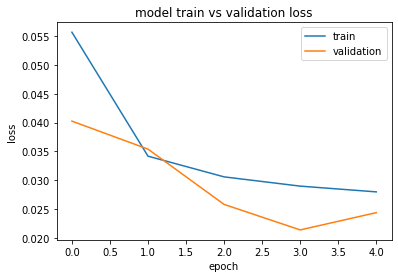

In [0]:
train_and_plot_history(AE)

In [0]:
AE.save('model/ae_celeb_model.h5')

In [0]:
files.download('model/ae_celeb_model.h5')

**2.6** Visualize 5 random original and reconstructed images fed to the autoencoder from the validation data.

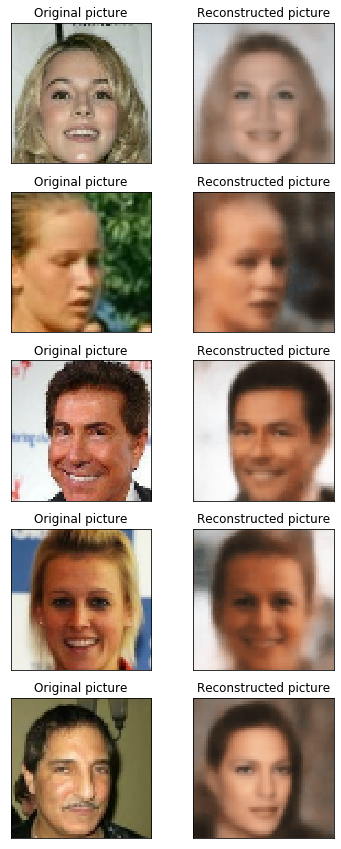

In [0]:
plt.figure(figsize = (6, 15))
grid = plt.GridSpec(5, 2, wspace=0.2, hspace=0.2)
imlist = []
data = val_ds.unbatch().take(5)
for img,_ in data.as_numpy_iterator():
    imlist.append(img)

pred_imgs = AE.predict(np.asarray(imlist))
for i,img in enumerate(imlist):
    plt.subplot(grid[i, 0])
    fig1 = plt.imshow(img)
    fig1.axes.get_xaxis().set_visible(False)
    fig1.axes.get_yaxis().set_visible(False)
    plt.title("Original picture")
    plt.subplot(grid[i, 1])
    fig2 = plt.imshow(pred_imgs[i])
    fig2.axes.get_xaxis().set_visible(False)
    fig2.axes.get_yaxis().set_visible(False)
    plt.title("Reconstructed picture")  

**2.7** Visualize the first 2 [principal components](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) projection onto the plane of the latent representation of the validation images. Use the representation after the first dense layer where `bottleneck_dim=128` to compute the PCs and t-SNE projections. Retrieve at least `1024` images and color each input by class type, for example, `Male` and `Smiling` (if these where your chosen attributes), for **each scatter plot visualization** and attributes. You need to present 4 scatter plots in total. Explain your results.

In [0]:
def draw(model,mode='pca',cond=False):
    flag=0;
    for layer in model.layers:
        if layer.name=="encoder":
            flag=1;break;
    if flag:
        for layer in model.get_layer("encoder").layers:
            if layer.name=="flat_cond":
                flag=0;break;
        if flag:
            thelayer = model.get_layer("encoder").get_layer("dense1")
            intermediate_model = models.Model(inputs=model.layers[0].input, outputs=thelayer.output)
        else:
            thelayer = model.get_layer("encoder").get_layer("flat_cond")
            intermediate_model = models.Model(inputs=[model.layers[0].input,model.layers[1].input], outputs=thelayer.output)
    else:
        thelayer = model.get_layer("dense1")
        intermediate_model = models.Model(inputs=model.layers[0].input, outputs=thelayer.output)

    # get the prediction
    imgs=[]
    attrs = []
    val_data = val_cond_ds.unbatch().take(1024)
    for (img,attr),_ in val_data.as_numpy_iterator():
        imgs.append(img)
        attrs.append(attr)

    imgs= np.asarray(imgs)
    attrs = np.asarray(attrs)
    if cond:
        results=intermediate_model.predict([imgs,attrs]).reshape(1024,-1)
    else:
        results=intermediate_model.predict(imgs).reshape(1024,-1)

    # compute pca
       
    if mode=='pca':
        pca = PCA(n_components=2)
        fitted_pca = pca.fit(results)
        pca_latent_train = fitted_pca.fit_transform(results)
        latent_plot(pca_latent_train,attrs,fitted_pca=fitted_pca)
    elif mode=='tsne':
        tsne = TSNE(n_components=2).fit_transform(results)
        latent_plot(tsne,attrs,'tsne')
            
# plotting
def latent_plot(data,attrs,mode='pca',fitted_pca=None):
    df = pd.DataFrame({'pca1':data[:,0],'pca2':data[:,1],'attr1':attrs[:,0],'attr2':attrs[:,1]})
    plt.figure(figsize = (12, 5))
    grid = plt.GridSpec(1, 2, wspace=0.2, hspace=0.2)
    color = {0:'r',1:'b'}
    labels =  [{0:'Female',1:'Male'},{0:'Not smiling',1:'Smiling'}]

    for k in range(2):
        plt.subplot(grid[0, k])
        for i in range(2):
            data = df[df['attr'+str(1+k)]==i]
            plt.scatter(data.pca1,data.pca2,c=color[i],label=labels[k][i])
            if mode =='pca':
                plt.xlabel("PC1 ({}%)".format(np.round(100*fitted_pca.explained_variance_ratio_[0],1)))
                plt.ylabel("PC2 ({}%)".format(np.round(100*fitted_pca.explained_variance_ratio_[1],1)))
        plt.legend()

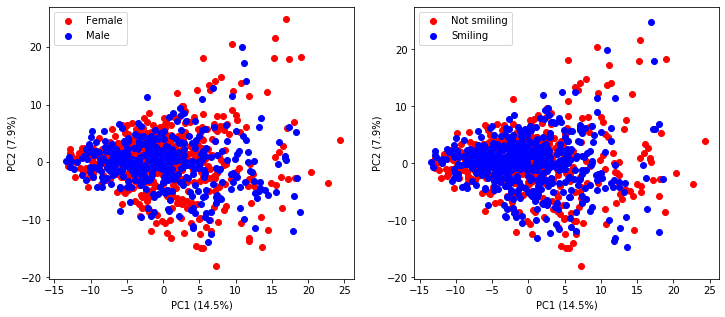

In [0]:
draw(AE, mode='pca')

*Your answer here*


* I think from the PCA plots, we can not distinguish "Male and Femal" and "Smiling and Not smiling" well. They have large overlapping areas, and all the data are distributed in a cone-like area. This indicates that the latent space data is "right-skewed" to some extent.

* This makes sense. Because the faces of Male and Female are similar. They all have five organs at similar positions for Male-Female detection. What's worse, some males can have long hair, which make the most significant difference of Male and Female more ambiguous. Also, Smiling and Not smiling only have little differences on mouth and eyes. They are really hard to detect.

* PCA only shows the two most information intensive directions, which will contain the "main information" like five organs and their positions. These two dimensions may not focus on the details like the shape of mouth or eyes.

* The x-axis span is greater than y-axis, which indicates that data are more sparse in the main direction than second main direction. By the way, the left and right plots have the same data distribution, but just the different labels, which is trivial.

Compute also the t-SNE decomposition of the latent images. Does it uncover any characteristic structure? Please, explain your answer

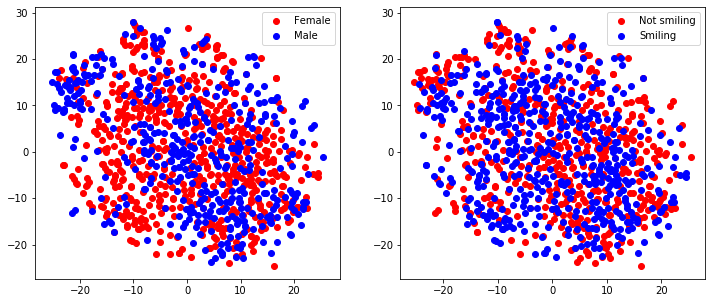

In [0]:
draw(AE,'tsne')

*Your answer here*


* T-distributed Stochastic Neighbor Embedding converts similarities between data points to joint probabilities and tries to minimize the KL divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

* I think that makes it a better tool to visualize high dimensional data. From the t-SNE plots, the "Male and Femal" and "Smiling and Not smiling" data can be well distinguished. They have overlapping areas, but not so much as PCA plots, also not so intensive distributed as PCA plots. On the contrary, they seem to be uniformly distributed in a circle area.

* Finally, from my eyeball-ditection, the model performs better on "Male-Female" task than "Smiling-Not smiling" task. That makes sense, because "Male-Female" has more differences such as hair, face outline, eyes, mouth shape, but "Smiling-Not smiling" only has differences on subtle details of mouth or eyes.

---

<div class='exercise'> <b> Question 3: Set-up a Convolutional Variational Autoencoder [20 points].</b> </div>

In this exercise you will code a standard Variational Autoencoder. You will first create a custom layer `Sampling` that takes the mean and log-variance of a Gaussian distribution as inputs, and returns a sample from that distribution. You will use this sample as a latent representation of your probabilistic encoder conditioned on the input image, and use it to reconstruct an image. You will build the complete VAE architecture and study its properties.

You will need to minimize the negative ELBO function formed by a reconstruction loss and a regularization term over the mean and variance of the probabilistic encoder. You will train two VAE models, one with no regularization, and a second with regularization.

Follow these instructions:

**3.1** Complete the `call` function of Sampling keras layer. This function takes as input the mean and log-variance vectors of a multivariate Gaussian distribution and returns a sampled tensor from this distribution.

**3.2** Create two  Variational AutoEncoder models named `VAE1` and `VAE2`. Use the `ConvEncoder` and `ConvDecoder` layer classes you completed in Question 2 and the `Sampling` layer from 3.1. Both VAEs should have the following architecture:
- Input image.
- ConvEncoder.
- Flatten layer.
- Dense layer with linear activation and 128 units to predict the mean of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Dense layer with linear activation and 128 units to predict the log-variance of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Sampling layer you completed in Question 3.1.
- Dense layer with ReLu activation.
- Reshape layer: reshapes the output of dense into `latent_dim`.
- ConvDecoder.

Finally, `VAE1` should not use any regularization of the probabilistic encoder (from the prior). 

Instead, `VAE2` should incorporate a KL loss to regularize the probabilistic encoder to normal Gaussian of zero mean and unit variance acting as prior, as explained in class. 
You may use the following expression: `kl_loss = - reg * 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)`, where a reasonable value for `reg = 0.1` (feel free to adjust).
To include the intermediate loss in `VAE2`, you may use the function `add_loss` from keras models/layers as explained in the [documentation](https://www.tensorflow.org/guide/keras/train_and_evaluate). 

**We recommend saving your trained models.**

**3.3** Why do we use linear activation values to encode the mean and log-variance of the probabilistic encoder? Explain your answer.

**3.4** Visualize 1 original image and 5 reconstructed images from the validation data fed to `VAE1` and `VAE2`. Comment on the reconstructed images. Notice that you may need to tune penalty regularization term to observe differences between `VAE1` and `VAE2` (there should be differences!).

**3.5** Visualize the first 2 principal components (PCs) and the t-SNE decomposition of the validation data on both `VAE1` and `VAE2` obtained from the latent space, i.e., a sample drawn from the probabilistic encoder for a given input. Color the datapoints depending on the input's attributes of your choice (`Male` and `Smiling` if these were your choice). Draw four separate scatterplots in total. Explain what you observe.

## Answers

**3.1** Complete the `call` function of Sampling keras layer. This function takes as input the mean and log-variance vectors of a multivariate Gaussian distribution and returns a sampled tensor from this distribution.

In [0]:
class Sampling(layers.Layer):
    """
    Sampling layer in latent space.
    Uses (z_mean, z_log_var) to sample z.
    """

    def call(self, inputs):
        """Rturns a random sample from a Gaussian with mean and 
        log-variance indicated in inputs.
        
        Inputs:
        -inputs: tuple (z_mean, z_log_var)
        
        Returns a sample z drawn from Gaussian.
        """
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=(128,))
        return z_mean+tf.exp(0.5 * z_log_var) * epsilon
        # your code here
    def get_config(self):

        config = super().get_config().copy()
        config.update({
        })
        return config



**3.2** Create two  Variational AutoEncoder models named `VAE1` and `VAE2`. Use the `ConvEncoder` and `ConvDecoder` layer classes you completed in Question 2 and the `Sampling` layer from 3.1. Both VAEs should have the following architecture:
- Input image.
- ConvEncoder.
- Flatten layer.
- Dense layer with linear activation and 128 units to predict the mean of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Dense layer with linear activation and 128 units to predict the log-variance of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Sampling layer you completed in Question 3.1.
- Dense layer with ReLu activation.
- Reshape layer: reshapes the output of dense into `latent_dim`.
- ConvDecoder.

Finally, `VAE1` should not use any regularization of the probabilistic encoder (from the prior). 

Instead, `VAE2` should incorporate a KL loss to regularize the probabilistic encoder to normal Gaussian of zero mean and unit variance acting as prior, as explained in class. 
You may use the following expression: `kl_loss = - reg * 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)`, where a reasonable value for `reg = 0.1` (feel free to adjust).
To include the intermediate loss in `VAE2`, you may use the function `add_loss` from keras models/layers as explained in the [documentation](https://www.tensorflow.org/guide/keras/train_and_evaluate). 

**We recommend saving your trained models.**

In [0]:
def build_vae(mode='1',load=False):
    bottleneck_dim=128
    latent_dim = [32,32,64]
    inputs = layers.Input(shape=input_size,name='Input_layer')
    encoded = ConvEncoder(input_shape = input_size,name='convencoder')(inputs)
    flattenner = layers.Flatten(name='flatten1')(encoded)
    dense1 = layers.Dense(bottleneck_dim,activation='linear',name='dense1')(flattenner)
    z_mean = layers.Dense(bottleneck_dim,activation='relu',name='z_mean')(dense1)
    z_log_var = layers.Dense(bottleneck_dim,activation='relu',name='z_log_var')(dense1)
    sample = Sampling(name='sampling')((z_mean,z_log_var ))
    dense2 = layers.Dense(np.prod(latent_dim),activation='relu',name='dense2')(sample)
    reshaped = layers.Reshape((*latent_dim,),name='reshape')(dense2)

    latent = layers.Input(shape=(*latent_dim,),name='Input')
    decoded = ConvDecoder(input_shape = (*latent_dim,),name='convdecoder')(latent)

    encoder = tf.keras.models.Model(inputs, [z_mean, z_log_var, reshaped], name='encoder')
    decoder = models.Model(inputs = latent, outputs = decoded,name='Decoder') 
    outputs = decoder(encoder(inputs)[2])

    VAE = models.Model(inputs=inputs, outputs= outputs, name='VAE'+mode)
    if mode=='1':
        VAE.compile(optimizer='adam', loss='mse')
    elif mode=='2':       
        reconstruction_loss = tf.keras.losses.mse(inputs,outputs)
        reconstruction_loss *= 64*64*3
        reg=0.1
        kl_loss = - reg * 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)

        #Define vae_loss as mean of (reconstruction loss + KL loss)
        vae_loss = tf.keras.backend.mean(reconstruction_loss+kl_loss)
        VAE.add_loss(vae_loss)
        VAE.compile(optimizer='adam',loss=None)
    print(VAE.summary())
    if os.path.exists("model/vae"+mode+"_celeb_model.h5") and load is True:
        VAE.load_weights("model/vae"+mode+"_celeb_model.h5")
    return VAE

In [0]:
VAE1 = build_vae(mode='1', load=True)

Model: "VAE1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 64, 64, 3)]       0         
_________________________________________________________________
encoder (Model)              [(None, 128), (None, 128) 8688816   
_________________________________________________________________
Decoder (Model)              (None, 64, 64, 3)         172368    
Total params: 8,861,184
Trainable params: 8,861,184
Non-trainable params: 0
_________________________________________________________________
None


# Do not run this again!

# Do not run this again!

# Do not run this again!

Epoch 1/5
1024/1024 [==============================] - 77s 75ms/step - loss: 0.0904 - val_loss: 0.0609
Epoch 2/5
1024/1024 [==============================] - 77s 75ms/step - loss: 0.0398 - val_loss: 0.0457
Epoch 3/5
1024/1024 [==============================] - 75s 73ms/step - loss: 0.0334 - val_loss: 0.0424
Epoch 4/5
1024/1024 [==============================] - 73s 71ms/step - loss: 0.0300 - val_loss: 0.0400
Epoch 5/5
1024/1024 [==============================] - 73s 71ms/step - loss: 0.0272 - val_loss: 0.0364


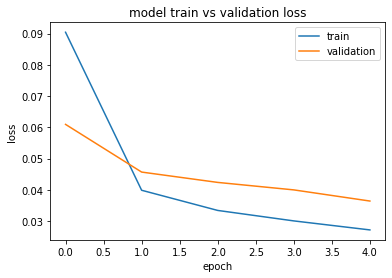

In [0]:
train_and_plot_history(VAE1) # default: take 1024 images

In [0]:
VAE1.save('model/vae1_celeb_model.h5')

In [0]:
VAE2 = build_vae(mode='2',load=True)

Model: "VAE2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer (InputLayer)        [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 128), (None, 8688816     Input_layer[0][0]                
__________________________________________________________________________________________________
Decoder (Model)                 (None, 64, 64, 3)    172368      encoder[1][2]                    
__________________________________________________________________________________________________
convencoder (ConvEncoder)       (None, 4, 4, 64)     70448       Input_layer[0][0]                
_______________________________________________________________________________________________

# Do not run this again

# Do not run this again

# Do not run this again

Epoch 1/5
1024/1024 [==============================] - 79s 77ms/step - loss: 551.1938 - val_loss: 588.4119
Epoch 2/5
1024/1024 [==============================] - 82s 80ms/step - loss: 323.7570 - val_loss: 461.9098
Epoch 3/5
1024/1024 [==============================] - 78s 76ms/step - loss: 286.8213 - val_loss: 372.1154
Epoch 4/5
1024/1024 [==============================] - 81s 80ms/step - loss: 271.9894 - val_loss: 268.2979
Epoch 5/5
1024/1024 [==============================] - 79s 77ms/step - loss: 259.7699 - val_loss: 276.2376


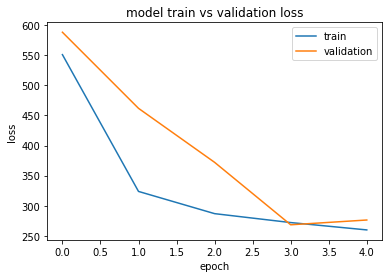

In [0]:
train_and_plot_history(VAE2)

In [0]:
VAE2.save('model/vae2_celeb_model_tf.h5', save_format="tf")

**3.3** Why do we use linear activation values to encode the mean and log-variance of the probabilistic encoder? Explain your answer.

*Your answer here*

* We use linear activation values to encode the mean and log-variance of the probablistic encoder, because the mean and log-variance can reach all the values on real numebr axis. Actually we need no non-linearity in this "regression" task to depict mean and log-variance vectors with no covatiances.

* Using activation like `Relu` or `sigmoid` can't reach the whole real axis. Using activation like `Leaky Relu` with cause the reagression has disfferent derivatives on positive and negative values, whcih might harm the training process.

**3.4** Visualize 1 original image and 5 reconstructed images from the validation data fed to `VAE1` and `VAE2`. Comment on the reconstructed images. Notice that you may need to tune penalty regularization term to observe differences between `VAE1` and `VAE2` (there should be differences!).

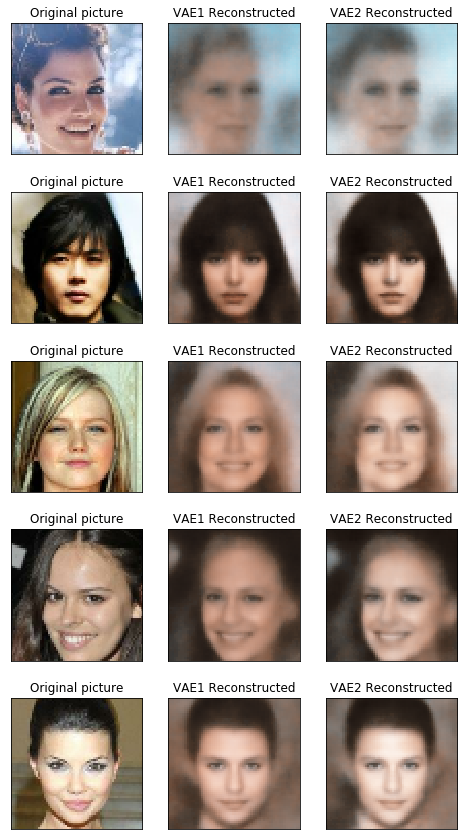

In [0]:
#VAE1.load_weights('model/vae1_celeb_model.h5')
#VAE2.load_weights('model/vae2_celeb_model.h5')

plt.figure(figsize = (8, 15))
grid = plt.GridSpec(5, 3, wspace=0.2, hspace=0.2)
imlist = []
data = val_ds.unbatch().take(5)
for img,_ in data.as_numpy_iterator():
    imlist.append(img)

vae1_pred_imgs = VAE1.predict(np.asarray(imlist))
vae2_pred_imgs = VAE2.predict(np.asarray(imlist))
for i,img in enumerate(imlist):
    plt.subplot(grid[i, 0])
    fig1 = plt.imshow(img)
    fig1.axes.get_xaxis().set_visible(False)
    fig1.axes.get_yaxis().set_visible(False)
    plt.title("Original picture")
    plt.subplot(grid[i, 1])
    fig2 = plt.imshow(vae1_pred_imgs[i])
    fig2.axes.get_xaxis().set_visible(False)
    fig2.axes.get_yaxis().set_visible(False)
    plt.title("VAE1 Reconstructed")
    plt.subplot(grid[i, 2])
    fig2 = plt.imshow(vae2_pred_imgs[i])
    fig2.axes.get_xaxis().set_visible(False)
    fig2.axes.get_yaxis().set_visible(False)
    plt.title("VAE2 Reconstructed")


*your explanation here*

* VAE2 performs better than VAE1. This is because the regularization sparse the latent object, which leads to higher distinction degree of different objects.

* They basically generate same images, but VAE2 provides clearer ones. See the fourth row of images, VAE2 decipts the woman's hair better. Also, see the last row. VAE2 smooths the woman face's outline, and make it more like a woman.

* Also, VAE2 generate more realistic colors. See the second row of images, the skin is brighter, and the eyes are more colorful and sparkling.


**3.5** Visualize the first 2 principal components (PCs) and the t-SNE decomposition of the validation data on both `VAE1` and `VAE2` obtained from the latent space, i.e., a sample drawn from the probabilistic encoder for a given input. Color the datapoints depending on the input's attributes of your choice (`Male` and `Smiling` if these were your choice). Draw four separate scatterplots in total. Explain what you observe.

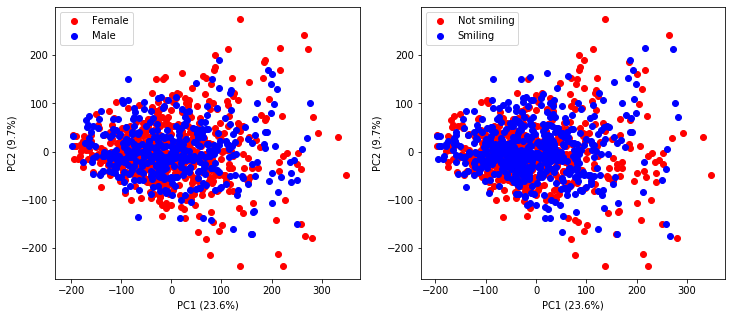

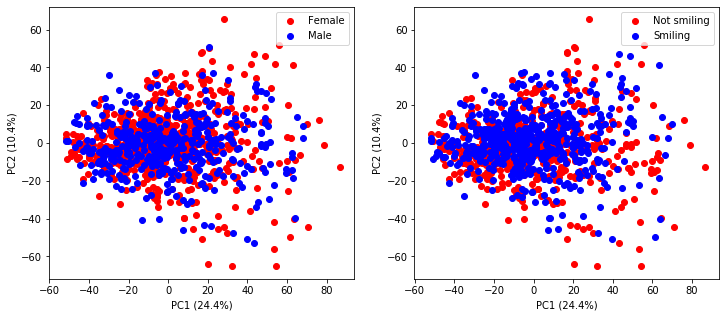

In [0]:
draw(VAE1)
draw(VAE2)

**Explanation of PCA visualization:** 

*your explanation here*

* Still, in the PCA plots, all the data are distributed in a cone-like area, which indicate the data is "right-skewed". Also the x-axis span lager than y-axis, which indicates the main direction decipt a heavly variate direction.

* Also, we can see the span of VAE1 is lager than that of VAE2 in PCA plots. This is because the regularization prevent data to be too various in one dimension.

* If we carefully observe the plots, we can see some similar shape of the data distribution in VAE1 and VAE2 PCA plots, like the highest data point. This is because the two models have similar architectures and provide similar structured latent space.


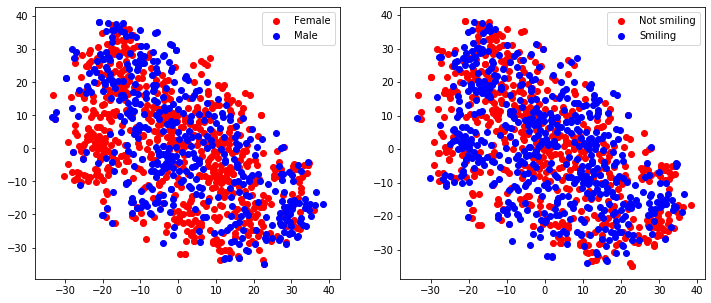

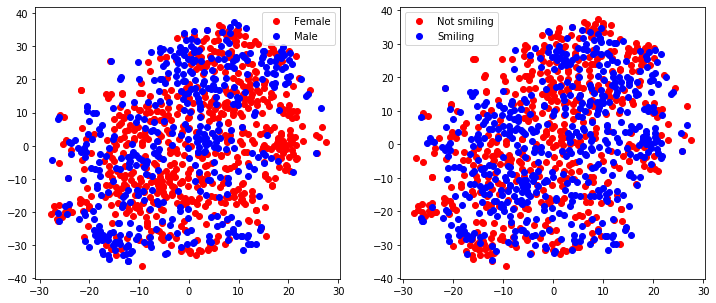

In [0]:
draw(VAE1,'tsne')
draw(VAE2,'tsne')

**Explanation of t-SNE decomposition:** 

*your explanation here*

* All the AE, VAE1 and VAE2 plots have similar spans, although VAEs slitely larger than AE, which means VAE can sparse the latent space representation. T-SNE can describe the panorama of higher dimensional distribution, not just the two main directions. So the spans will not be so different if the high dimensional distributions are similar.

* The shape of projected distributions in latent space is oval-like for VAEs, instead of circle-like shape for AEs. I don't knwo why, but I guess the sampling of high dimensional data will tends to sparse some dimensions than others.

* As the same with 2.7, from my eyeball-ditection, the model performs better on "Male-Female" task than "Smiling-Not smiling" task. That makes sense, because "Male-Female" has more differences such as hair, face outline, eyes, mouth shape, but "Smiling-Not smiling" only has differences on subtle details of mouth or eyes.

<div class='exercise'> <b> Question 4: Set-up a Conditional VAE. [20 points] </b> </div>

Conditional VAEs are similar to standard VAEs were you incorporate an input's label/information into the latent space. When the model is trained in this form, the model learns to distinguish between these features. For example, you can select features on latent space manually, and explore the space of representations in an explicit manner. We point you to [one](https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/) and [two](https://ijdykeman.github.io/ml/2016/12/21/cvae.html) short tutorials on conditional VAEs. Additionally, you may be interested in reading the [original paper](http://papers.nips.cc/paper/5775-learning-structured-output-representation-using-deep-conditional-generative-models.pdf), or a [continuation paper](https://papers.nips.cc/paper/7880-learning-latent-subspaces-in-variational-autoencoders.pdf). 

In this exercise you are going to build a conditional VAE, and reconstruct images by altering their attributes. For example, pick a set of 'not smiling men' and transform them by changing the label conditions such as 'smile' or 'gender' in latent space. You can choose whatever attributes you want, as long as the reconstructed latent space shows reasonable success when changing the attribute labels.

Follow this set of instructions:

**4.1** Create a conditional VAE keras model named `CVAE`. The conditional VAE should have the following architecture:
- Input for image.
- Input for attributes.
- ConvEncoder layer.
- Flatten layer: flattens the output of the ConvEncoder.
- [Concatenate layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate): concatenates the latent representation of dimension `latent_dim[0]*latent_dim[1]*latent_dim[2]` with two attribute codes of your choice (tf.float32 representations).
- Dense layer with linear activation and `bottleneck_dim` units to predict the mean of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Dense layer with linear activation and `bottleneck_dim` units to predict the log-variance of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Sampling layer you completed in Question 3.1.
- [Concatenate layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate) that combines your sample with the two attribute codes of your choice (tf.float32 representations).
- Dense layer with ReLu activation.
- Reshape layer.
- ConvDecoder.
- Output image of same size as input image.

**4.2** Train the model using the data generator you completed in Question 1.2 (use mean squared error loss and an optimizer of your choice). Print a summary of your model.

**We recommend saving your trained models**.

**4.3** Select 5 photos with common attributes and reconstruct these images after feeding them to the conditional variational autoencoder `CVAE` from the validation data. Change attributes in the other three possible combinations and visualize all compositions. Comment on your compositions.

For example, if your choice of attributes where 'Male' and 'Smiling', you should reconstruct these images with all possible attribute combinations.

**4.4** Visualize the first 2 principal components and the t-SNE decomposition of the validation data of `CVAE` obtained from the latent space, i.e., a sample drawn from the probabilistic encoder for at least 1024 input images. Color the datapoints depending on the input's attributes `male` and `smiling`: draw four separate scatterplots in total. Explain what you observe.

## Answers

**4.1** Create a conditional VAE keras model named `CVAE`. The conditional VAE should have the following architecture:
- Input for image.
- Input for attributes.
- ConvEncoder layer.
- Flatten layer: flattens the output of the ConvEncoder.
- [Concatenate layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate): concatenates the latent representation of dimension `latent_dim[0]*latent_dim[1]*latent_dim[2]` with two attribute codes of your choice (tf.float32 representations).
- Dense layer with linear activation and `bottleneck_dim` units to predict the mean of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Dense layer with linear activation and `bottleneck_dim` units to predict the log-variance of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Sampling layer you completed in Question 3.1.
- [Concatenate layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate) that combines your sample with the two attribute codes of your choice (tf.float32 representations).
- Dense layer with ReLu activation.
- Reshape layer.
- ConvDecoder.
- Output image of same size as input image.

In [0]:
def build_cvae(load=False):
    bottleneck_dim=128
    latent_dim = [32,32,64]
    # Encoder
    aeinput = layers.Input(shape=input_size,name='Input_layer')
    cond = layers.Input(shape=(2,),name='Input_label1')
    convencoder = ConvEncoder(input_shape = input_size,name='convencoder')(aeinput)
    flattenner = layers.Flatten(name='flatten1')(convencoder)
    flat_cond = layers.Concatenate(name='flat_cond')([flattenner,cond])
    z_mean = layers.Dense(bottleneck_dim,activation='relu',name='z_mean')(flat_cond)
    z_log_var = layers.Dense(bottleneck_dim,activation='relu',name='z_log_var')(flat_cond)
    z = Sampling(name='sampling')([z_mean,z_log_var])
    z_cond = layers.Concatenate()([z,cond])
    dense2 = layers.Dense(np.prod(latent_dim),activation='relu',name='dense2')(z_cond)
    reshaper = layers.Reshape((*latent_dim,),name='reshape')(dense2)
    # Decoder
    latent = layers.Input(shape=(*latent_dim,),name='Input')
    convdecoder=ConvDecoder(input_shape = (*latent_dim,),name='convdecoder')(latent)
    # compile the encoder and decoder
    encoder = tf.keras.models.Model([aeinput,cond], [z_mean, z_log_var, reshaper], name='encoder')
    decoder = models.Model(inputs = latent,outputs = convdecoder,name='Decoder') 
    outputs = decoder(encoder([aeinput,cond])[2])
    # Define vae_loss as mean of (reconstruction loss + KL loss)
    CVAE = models.Model(inputs=[aeinput,cond],outputs= outputs,name='CVAE')
    reconstruction_loss = tf.keras.losses.mse(aeinput,outputs)
    reconstruction_loss *= 64*64*3
    reg=0.1
    kl_loss = - reg * 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    # compile the model
    vae_loss = tf.keras.backend.mean(reconstruction_loss+kl_loss)
    CVAE.add_loss(vae_loss)
    CVAE.compile(optimizer='adam',loss=None)
    if os.path.exists("model/cvae_celeb_model.h5") and load is True:
        CVAE.load_weights("model/cvae_celeb_model.h5")
    print(CVAE.summary())    
    return CVAE

In [0]:
CVAE = build_cvae(load=True)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Input_label1_1:0


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Input_label1_1:0


Model: "CVAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer (InputLayer)        [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Input_label1 (InputLayer)       [(None, 2)]          0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 128), (None, 8918576     Input_layer[0][0]                
                                                                 Input_label1[0][0]               
__________________________________________________________________________________________________
Decoder (Model)                 (None, 64, 64, 3)    172368      encoder[1][2]                 

**4.2** Train the model using the generator you completed in Q1.3. Print a summary of your model.
**We recommend saving your trained models**.

In [0]:
train_and_plot_history(CVAE,size=1024,train=train_cond_ds,val=val_cond_ds)
CVAE.save('model/cvae_celeb_model.h5',save_format="tf")

**4.3** Select 5 photos with common attributes and reconstruct these images after feeding them to the conditional variational autoencoder `CVAE` from the validation data. Change attributes in the other three possible combinations and visualize all compositions. Comment on your compositions.

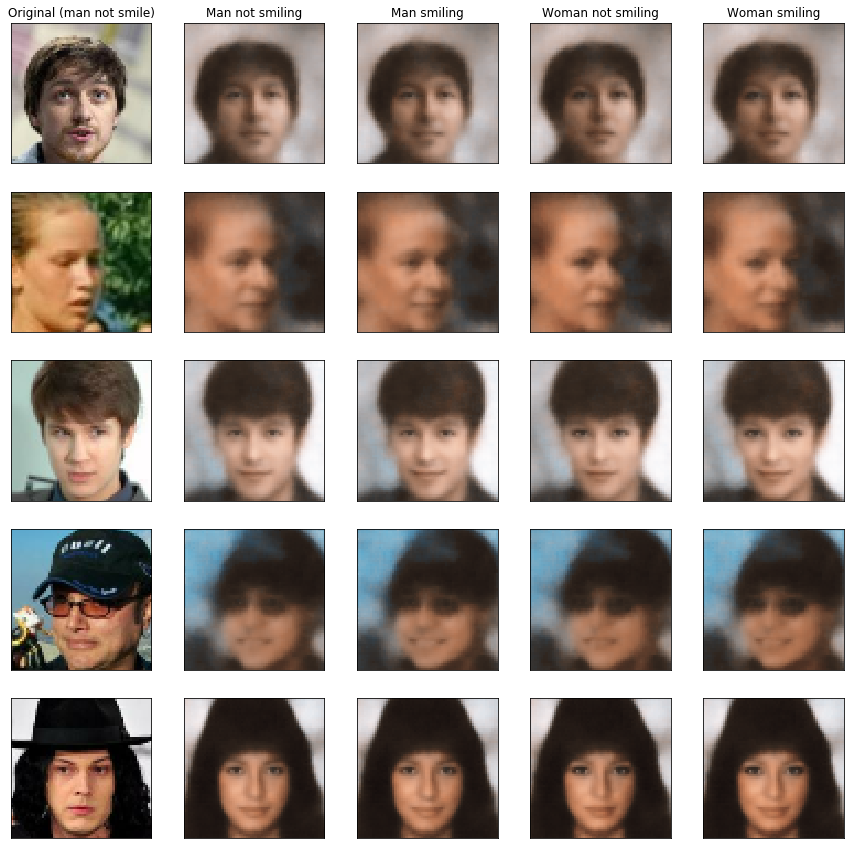

In [0]:
#CVAE.load_weights('model/cvae_celeb_model.h5')

plt.figure(figsize = (15, 15))
grid = plt.GridSpec(5, 5, wspace=0.2, hspace=0.2)
imlist = []
data = val_cond_ds.unbatch().take(30)
idx = 0
for (img,attr),_ in data.as_numpy_iterator():
    if attr[0]==1 and attr[1]==0:
        imlist.append(img)
        idx+=1
    if idx==5:
        break

cvae_mannosm = CVAE.predict([np.asarray(imlist),np.ones((5,1))@np.array([[1,0]])])
cvae_mansm = CVAE.predict([np.asarray(imlist),np.ones((5,1))@np.array([[1,1]])])
cvae_womannosm = CVAE.predict([np.asarray(imlist),np.ones((5,1))@np.array([[0,0]])])
cvae_womansm = CVAE.predict([np.asarray(imlist),np.ones((5,1))@np.array([[0,1]])])
predicts = [imlist,cvae_mannosm,cvae_mansm,cvae_womannosm,cvae_womansm ]
titles=["Original (man not smile)","Man not smiling","Man smiling","Woman not smiling","Woman smiling"]
for i,img in enumerate(imlist):
    for j in range(5):
        plt.subplot(grid[i, j])
        fig = plt.imshow(predicts[j][i])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        if i==0:
            plt.title(titles[j])

*Your answer here*

* I should say it's amazing to see CVAE really changes some details of mouth and eyes to make the picture have attributes of the lable.

* As we choose "Male-Not smiling" as our base images' labels, we can tell that "Male-Not smile" label is well reconstructed here. 

* When we look at "Smiling", we can easily tell the corners of the mouths go up here compared with "Not smiling". Also the eyes curve more arc on smiling faces than not-smiling faces.

* When it comes to "Female" labels, really the eyelashes are thicker and the face outlines are softer. But the hair doesn't change so much, maybe because it learns that men can also have long hair and women can also have short hair.

**4.4** Visualize the first 2 principal components and the t-SNE decomposition of the validation data of `CVAE` obtained from the latent space, i.e., a sample drawn from the probabilistic encoder for at least 1024 input images. Color the datapoints depending on the input's attributes `male` and `smiling`: draw four separate scatterplots in total. Explain what you observe.

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Input_label1:0


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Input_label1:0


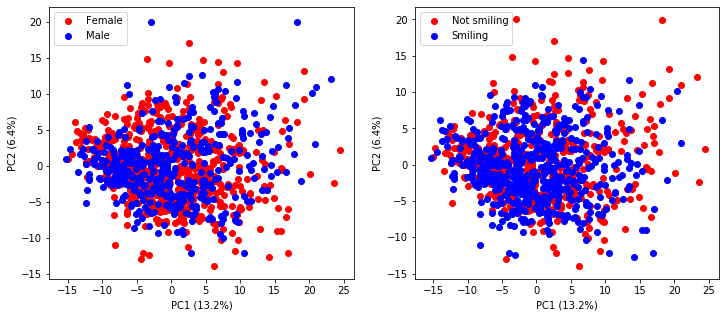

In [0]:
draw(CVAE,'pca','cond')

*Your answer here*

* We can't say this is a cone-like distribution in comparison with AE and VAEs. This indicates the latent space data isn't so "right-skewed" as AE and VAEs.

* Again, from my eyeball-detection, the model performs better in "Male-Female" task than "Smiling-Not smiling task". I can tell this even by PCA plot now, which means CVAE can tell the differences of man and women only use the two main directions. This may be because CVAE encodes label information into latent space, which helps the model to represent data better.

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Input_label1:0


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Input_label1:0


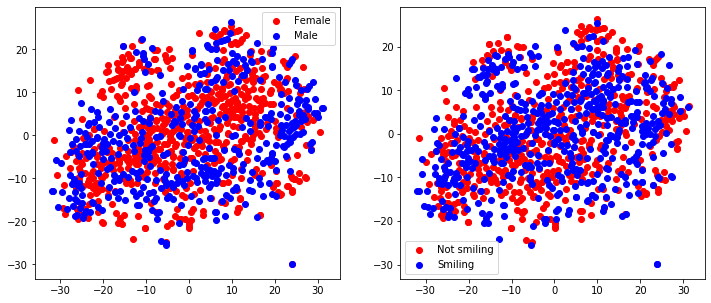

In [0]:
draw(CVAE,'tsne','cond')

*Your answer here*


* The t-SNE plots of CVAE model are not so different from CVAEs'.Just they seems distinguish the "Male-Female" and "Smiling-Not smilig" lables better. This may be because CVAE encodes label information into latent space, which helps the model to represent data better.

* Still they are oval-like distributed, instead of circle-like shape for AEs, and perform better on "Male-Female" task than "Smiling-Not smiling" task. The reason is the same with 3.5.

---

<div class='exercise'> <b> Question 5: Generative Adversarial Networks. [20 points] </b> </div>

For the final exercise we are going to create a standard GAN composed of a generator, and a discriminator. GANs are tricky to train, so we encourage you to follow the given instructions when training your models. However, feel completely free to explore and present other layer architectures if they present better results.

**5.1** Create a convolutional keras generator model. We recommend the follow architecture.

- Input to the generator is a noise vector of dimension `bottleneck_dim`. You can rename to `noise_dim` for more corresponding terminology if you prefer.
- Dense layer with `latent_dim[0]*latent_dim[1]*latent_dim[2]` units, and LeakyRelu.
- Reshape to `latent_dim`.
- 3x Conv2DTranspose layers with 5x5 filters, LeakyRelu's, stride 2x2, 'same' padding.

For stability, consider training without bias terms on your Dense and Conv2DTranspose layers. Print a summary of your model.

**5.2** Create a convolutional discriminator model. Our recommended setup is to use 3x Conv2D layers with filters of size (4,4), 'same' padding, strides 2x2, and LeakyRelu activations. Compile the model with binary cross entropy loss and an optimizer of your choice. Print a summary of the model.

**5.3** Create a DCGAN model that is a composition of the generator and the discriminator. The DCGAN model takes a Gaussian vector as input into the generator, and then the discriminator decides whether the output comes from the generator or from the true distristribution. The DCGAN is composed of the trainable weights of the generator, and fixed discriminator weights. You can accompolish this behavior by fixing the discriminator training weights using `discriminator.trainable = False` before constructing the model. Once you have instantiated the DCGAN model, compile it with a binary cross entropy loss and optimizer of your choice.

**5.4** Train your model (both DCGAN and discriminator) on the train images of the celeba dataset. We recommend you display images after every train epoch to visualize performance. You should observe 'sensible' images after around 5 epochs or less, specially if you train on the full dataset. Consider training on a reduced set of the dataset if it takes too long. 

To train your DCGAN model, you will not be able to use the model's [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) function. Instead, you should consider using [`train_on_batch`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_on_batch) method, where you can manually feed an input and training labels, and alternate between the DCGAN and the discriminator. Datasets are `iterable`, so you can use them directly in a for loop to obtain mini-batches. You need to run these three steps inside the for loop: 
1) Train on batch the discriminator on real images with labels equal to 1 (optionally, minus a small smoother). The smoother may help the generator train faster than the discriminator.
2) Train on batch the discriminator on generated images obtained from random Gaussian input and labels equal to 0.
3) Train on batch the DCGAN by feeding noise inputs and labels of 1's.

**Show at least 8 generated images from your final trained DCGAN model for submission**. How do these images compare in quality to the faces generated via VAE? Explain.

**5.5** Standard GANs are composed as a generator and discriminator, as you just coded them. Could we substitute the discriminator with something else, like a KL loss with the empirical distribution? Why or why not? Explain your answer.

## Answers

**5.1** Create a convolutional keras generator model. We recommend the follow architecture.

- Input to the generator is a noise vector of dimension `bottleneck_dim`. You can rename to `noise_dim` for more corresponding terminology if you prefer.
- Dense layer with `latent_dim[0]*latent_dim[1]*latent_dim[2]` units, and LeakyRelu.
- Reshape to `latent_dim`.
- 3x Conv2DTranspose layers with 5x5 filters, LeakyRelu's, stride 2x2, 'same' padding.

For stability, consider training without bias terms on your Dense and Conv2DTranspose layers. Print a summary of your model.

In [0]:
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
adam = Adam(lr=0.0002, beta_1=0.5)

# (a) GENERATOR
bottolneck_dim = 128  
noise_dim = bottolneck_dim
latent_dim = (8,8,10)
g= models.Sequential()
g.add(layers.Input(shape = (noise_dim,),name = 'gen_input'))
g.add(layers.Dense(latent_dim[0]*latent_dim[1]*latent_dim[2], use_bias=False,input_dim=noise_dim, activation=LeakyReLU(alpha=0.2),name = 'gen_dense1'))
g.add(layers.Reshape(latent_dim,name='gen_reshaper'))
g.add(layers.Conv2DTranspose(filters=9, kernel_size=(5,5), strides=(2,2), use_bias=False,padding='same',name='conv1', activation=LeakyReLU(alpha=0.2)))
g.add(layers.Conv2DTranspose(filters=18, kernel_size=(5, 5), strides=(2,2), use_bias=False,padding='same',name='conv2', activation=LeakyReLU(alpha=0.2)))
g.add(layers.Conv2DTranspose(filters=32, kernel_size=(5, 5), strides=(2,2), use_bias=False,padding='same',name='conv3', activation=LeakyReLU(alpha=0.2)))
g.add(layers.Conv2D(filters=3, kernel_size=(3, 3), strides=(1,1), use_bias=False,padding='same',name='conv4', activation=LeakyReLU(alpha=0.2)))
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
g.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_dense1 (Dense)           (None, 640)               81920     
_________________________________________________________________
gen_reshaper (Reshape)       (None, 8, 8, 10)          0         
_________________________________________________________________
conv1 (Conv2DTranspose)      (None, 16, 16, 9)         2250      
_________________________________________________________________
conv2 (Conv2DTranspose)      (None, 32, 32, 18)        4050      
_________________________________________________________________
conv3 (Conv2DTranspose)      (None, 64, 64, 32)        14400     
_________________________________________________________________
conv4 (Conv2D)               (None, 64, 64, 3)         864       
Total params: 103,484
Trainable params: 103,484
Non-trainable params: 0
_______________________________________________

**5.2** Create a convolutional discriminator model. Our recommended setup is to use 3x Conv2D layers with filters of size (4,4), 'same' padding, strides 2x2, and LeakyRelu activations. Compile the model with binary cross entropy loss and an optimizer of your choice. Print a summary of the model.

In [0]:

# 5.2
# your code here
d = models.Sequential()
d.add(layers.Input(shape=input_size))
d.add(layers.Conv2D(filters=9, kernel_size=(4, 4), strides=(2,2), use_bias=False,padding='same',name='dis_conv1', activation=LeakyReLU(alpha=0.2)))
d.add(layers.Conv2D(filters=18, kernel_size=(4, 4), strides=(2,2), use_bias=False,padding='same',name='dis_conv2', activation=LeakyReLU(alpha=0.2)))
d.add(layers.Conv2D(filters=32, kernel_size=(4, 4), strides=(2,2), use_bias=False,padding='same',name='dis_conv3', activation=LeakyReLU(alpha=0.2)))
d.add(layers.Flatten())
# d.add(Dropout(0.3))
d.add(layers.Dense(1, use_bias=False,activation ='sigmoid'))
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
d.summary()
# d.build()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dis_conv1 (Conv2D)           (None, 32, 32, 9)         432       
_________________________________________________________________
dis_conv2 (Conv2D)           (None, 16, 16, 18)        2592      
_________________________________________________________________
dis_conv3 (Conv2D)           (None, 8, 8, 32)          9216      
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2048      
Total params: 14,288
Trainable params: 14,288
Non-trainable params: 0
_________________________________________________________________


**5.3** Create a DCGAN model that is a composition of the generator and the discriminator. The DCGAN model takes a Gaussian vector as input into the generator, and then the discriminator decides whether the output comes from the generator or from the true distristribution. The DCGAN is composed of the trainable weights of the generator, and fixed discriminator weights. You can accompolish this behavior by fixing the discriminator training weights using `discriminator.trainable = False` before constructing the model. Once you have instantiated the DCGAN model, compile it with a binary cross entropy loss and optimizer of your choice.


In [0]:
# 5.3
# your code here
d.trainable = False
inputs = layers.Input(shape=(noise_dim, ))
hidden = g(inputs)
output = d(hidden)
dcgan = models.Model(inputs, output)
dcgan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
dcgan.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
sequential_10 (Sequential)   (None, 64, 64, 3)         103484    
_________________________________________________________________
sequential_11 (Sequential)   (None, 1)                 14288     
Total params: 117,772
Trainable params: 103,484
Non-trainable params: 14,288
_________________________________________________________________


**5.4** Train your model (both DCGAN and discriminator) on the train images of the celeba dataset. We recommend you display images after every train epoch to visualize performance. You should observe 'sensible' images after around 5 epochs or less, specially if you train on the full dataset. Consider training on a reduced set of the dataset if it takes too long. 

To train your DCGAN model, you will not be able to use the model's [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) function. Instead, you should consider using [`train_on_batch`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_on_batch) method, where you can manually feed an input and training labels, and alternate between the DCGAN and the discriminator. Datasets are `iterable`, so you can use them directly in a for loop to obtain mini-batches. You need to run these three steps inside the for loop: 
1) Train on batch the discriminator on real images with labels equal to 1 (optionally, minus a small smoother). The smoother may help the generator train faster than the discriminator.
2) Train on batch the discriminator on generated images obtained from random Gaussian input and labels equal to 0.
3) Train on batch the DCGAN by feeding noise inputs and labels of 1's.

**Show at least 8 generated images from your final trained DCGAN model for submission**. How do these images compare in quality to the faces generated via VAE? Explain.

In [0]:
# 5.4
# your code here
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=5, dim=(1, 5), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, noise_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 64, 64,3)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Epochs: 20
Batch size: 32
Batches per epoch: 2000
--------------- Epoch 1 ---------------


 Epoch: 1 	 Discr. Loss: 0.69070765376091 	 Gan Loss: [0.6958417892456055, 0.46875] 	 Time:  187.0531828403473


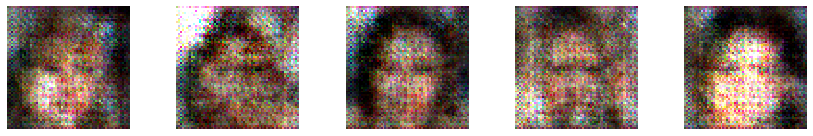

--------------- Epoch 2 ---------------


 Epoch: 2 	 Discr. Loss: 0.6855871677398682 	 Gan Loss: [0.6877950429916382, 0.625] 	 Time:  181.82338857650757


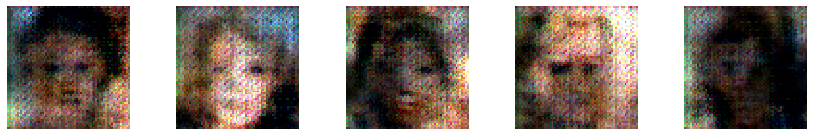

--------------- Epoch 3 ---------------


 Epoch: 3 	 Discr. Loss: 0.6828519105911255 	 Gan Loss: [0.698045015335083, 0.5] 	 Time:  181.82452154159546


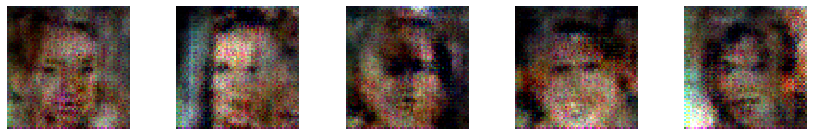

--------------- Epoch 4 ---------------


 Epoch: 4 	 Discr. Loss: 0.6965799927711487 	 Gan Loss: [0.6838953495025635, 0.59375] 	 Time:  181.72092151641846


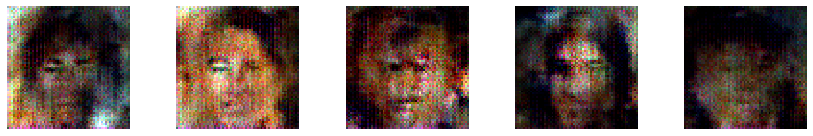

--------------- Epoch 5 ---------------


 Epoch: 5 	 Discr. Loss: 0.6929318904876709 	 Gan Loss: [0.6885398626327515, 0.375] 	 Time:  178.70010256767273


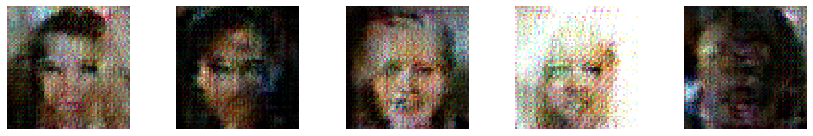

--------------- Epoch 6 ---------------


 Epoch: 6 	 Discr. Loss: 0.683273583650589 	 Gan Loss: [0.694758415222168, 0.5] 	 Time:  178.6716685295105


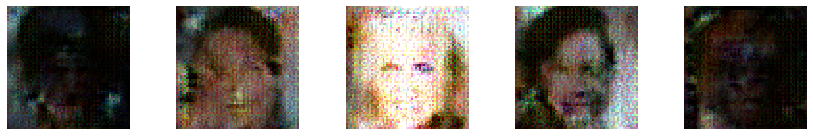

--------------- Epoch 7 ---------------


 Epoch: 7 	 Discr. Loss: 0.6826292872428894 	 Gan Loss: [0.6890122890472412, 0.59375] 	 Time:  180.41314673423767


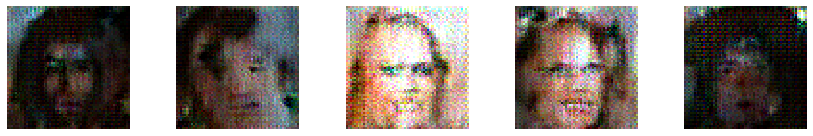

--------------- Epoch 8 ---------------


 Epoch: 8 	 Discr. Loss: 0.6885113716125488 	 Gan Loss: [0.6913161277770996, 0.59375] 	 Time:  176.65176367759705


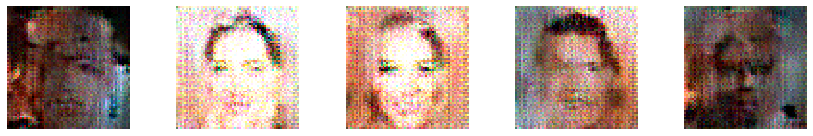

--------------- Epoch 9 ---------------


 Epoch: 9 	 Discr. Loss: 0.6903274655342102 	 Gan Loss: [0.710789680480957, 0.375] 	 Time:  178.9926106929779


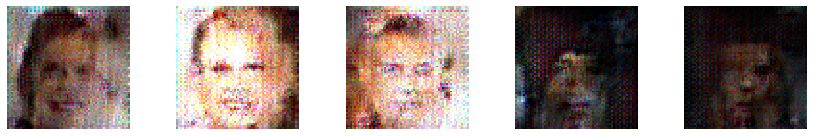

--------------- Epoch 10 ---------------

In [0]:
losses = {"D":[], "G":[]}
import time


epochs=20
plt_frq=1
BATCH_SIZE=32
batchCount =2000
train_ds_gan = train_celeb.map(lambda img: tf_norm_crop_resize_image(img["image"],input_size[:2]))
train_ds_gan = train_ds_gan.shuffle(20)
train_ds_gan = train_ds_gan.batch(BATCH_SIZE)
train_ds_gan = train_ds_gan.prefetch(10)
print('Epochs:', epochs)
print('Batch size:', BATCH_SIZE)
print('Batches per epoch:', batchCount)

for e in range(1, epochs+1):
  if e == 1 or e%plt_frq == 0:
    print('-'*15, 'Epoch %d' % e, '-'*15)
  start = time.time()
  for i,x_real in enumerate(train_ds_gan):  
    if i>batchCount:
      break
    if i%50==1:
      print("=",end='') 
    noise = np.random.normal(0, 1, size=(BATCH_SIZE, noise_dim))
    
    # Generate the images from the noise
    generated_images = g.predict_on_batch(noise)

    # Train discriminator on generated images
    d.trainable = True
    d_loss_real = d.train_on_batch(x_real,tf.ones((BATCH_SIZE,1))-0.1)
    d_loss_fake = d.train_on_batch(generated_images, tf.zeros((BATCH_SIZE,1)))
    d_loss = (d_loss_real[0]+d_loss_fake[0])/2
    # d_loss = d.train_on_batch(X, y)

    # Train generator
    noise = np.random.normal(0, 1, size=(BATCH_SIZE, noise_dim))
    y2 = np.ones(BATCH_SIZE)
    d.trainable = False
    g_loss = dcgan.train_on_batch(noise, y2)

  # Only store losses from final
  losses["D"].append(d_loss)
  losses["G"].append(g_loss)
  print(f'\n Epoch: {e} \t Discr. Loss: {d_loss} \t Gan Loss: {g_loss} \t Time: ', time.time()-start)
  # print(x_real[0])
  # Update the plots
  if e == 1 or e%plt_frq == 0:
    plot_generated()
plot_loss(losses)

**5.5** Standard GANs are composed as a generator and discriminator, as you just coded them. Could we substitute the discriminator with something else, like a KL loss with the empirical distribution? Why or why not? Explain your answer.



*your answer here*

---

If we substituted the discriminator with a KL loss, then the generator will try to generate pictures that are similar to those drawn from the empirical distribution. Instead of creatively combining human facial features to construct new faces, it will rigidly reproduce pictures similar to the existing ones. The process of game is also a process for the generator to learn to innovate.